# Shockwave

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import glob
import matplotlib.animation as animation

In [10]:
# Parameters
L = 1.0         # Length of the domain
T = 1           # Total simulation time
Nx = 201        # Number of spatial points
Nt = 800        # Number of time steps
dx = L / (Nx - 1)
dt = T / Nt

In [11]:
# Initial conditions
x = np.linspace(0, L, Nx)
gamma = 1.4
u = 0.75*np.ones(Nx) #np.exp(-(x - 0.5*L)**2 / 0.1)             # Velocity
u[60:] = 0
rho = np.ones(Nx)
rho[60:] = 0.125
press_i = np.ones(Nx)
press_i[60:] = 0.1

energy = np.zeros(Nx)
energy = press_i/((gamma - 1)) + 0.5*rho*u**2

In [12]:
x[60]

0.3

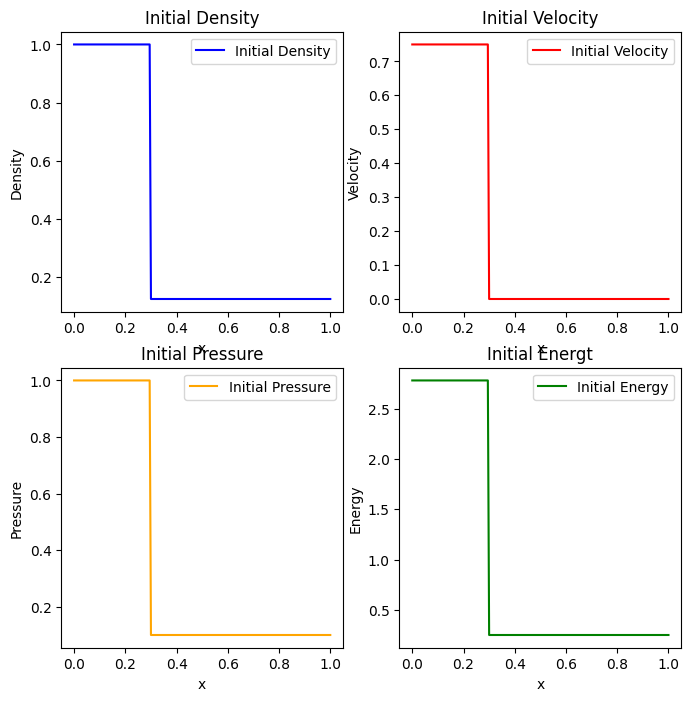

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0,0].plot(x, rho, label='Initial Density', color='blue')
axs[0,0].set_title('Initial Density')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('Density')
axs[0,0].legend()

axs[0,1].plot(x, u, label='Initial Velocity', color='red')
axs[0,1].set_title('Initial Velocity')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('Velocity')
axs[0,1].legend()

axs[1,0].plot(x, press_i, label='Initial Pressure', color='orange')
axs[1,0].set_title('Initial Pressure')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('Pressure')
axs[1,0].legend()

axs[1,1].plot(x, energy, label='Initial Energy', color='green')
axs[1,1].set_title('Initial Energt')
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('Energy')
axs[1,1].legend()

### Exact Solution

In [14]:
# Global variables
DL, UL, PL, DR, UR, PR = rho[0], u[0], press_i[0], rho[-1], u[-1], press_i[-1]
GAMMA, G1, G2, G3, G4, G5, G6, G7, G8 = gamma, None, None, None, None, None, None, None, None
CL, CR = np.sqrt(GAMMA*PL/DL), np.sqrt(GAMMA*PR/DR) 

DOMLEN, DIAPH, CELLS = L, 0.3, Nx

def compute_gamma_constants():
    global G1, G2, G3, G4, G5, G6, G7, G8
    G1 = (GAMMA - 1.0) / (2.0 * GAMMA)
    G2 = (GAMMA + 1.0) / (2.0 * GAMMA)
    G3 = 2.0 * GAMMA / (GAMMA - 1.0)
    G4 = 2.0 / (GAMMA - 1.0)
    G5 = 2.0 / (GAMMA + 1.0)
    G6 = (GAMMA - 1.0) / (GAMMA + 1.0)
    G7 = (GAMMA - 1.0) / 2.0
    G8 = GAMMA - 1.0

def guess_pressure():
    QUSER = 2.0
    CUP = 0.25*(DL + DR)*(CL + CR)
    PPV = max(0.0, 0.5 * (PL + PR) + 0.5 * (UL - UR) * CUP)
    PMIN = min(PL, PR)
    PMAX = max(PL, PR)
    QMAX = PMAX / PMIN
    if QMAX <= QUSER and (PMIN <= PPV and PPV <= PMAX):
        PM = PPV
    else:
        if PPV < PMIN:
            PQ = (PL / PR) ** G1
            UM = (PQ * UL / CL + UR / CR + G4 * (PQ - 1.0)) / (PQ / CL + 1.0 / CR)
            PTL = 1.0 + G7 * (UL - UM) / CL
            PTR = 1.0 + G7 * (UM - UR) / CR
            PM = 0.5 * (PL * PTL ** G3 + PR * PTR ** G3)
        else:
            GEL = np.sqrt((G5 / DL) / (G6 * PL + PPV))
            GER = np.sqrt((G5 / DR) / (G6 * PR + PPV))
            PM = (GEL * PL + GER * PR - (UR - UL)) / (GEL + GER)
    return PM

def prefun(P, DK, PK, CK):
    if P <= PK:
        PRAT = P / PK
        F = G4 * CK * (PRAT ** G1 - 1.0)
        FD = (1.0 / (DK * CK)) * PRAT ** (-G2)
    else:
        AK = G5 / DK
        BK = G6 * PK
        QRT = np.sqrt(AK / (BK + P))
        F = (P - PK) * QRT
        FD = (1.0 - 0.5 * (P - PK) / (BK + P)) * QRT
    return F, FD

def starpu():
    TOLPRE = 1.0E-06
    NRITER = 20
    PSTART = guess_pressure()
    POLD = PSTART
    UDIFF = UR - UL
    for i in range(1, NRITER + 1):
        FL, FLD = prefun(POLD, DL, PL, CL)
        FR, FRD = prefun(POLD, DR, PR, CR)
        P = POLD - (FL + FR + UDIFF) / (FLD + FRD)
        CHANGE = 2.0 * np.abs((P - POLD) / (P + POLD))
        if P < 0.0:
            P = TOLPRE
        POLD = P
        if CHANGE <= TOLPRE:
            break
    U = 0.5 * (UL + UR + FR - FL)
    return P, U

def sample(PM, UM, S):
    if S <= UM:
        if PM <= PL:
            SHL = UL - CL
            if S <= SHL:
                D = DL
                U = UL
                P = PL
            else:
                CML = CL*(PM/PL)**G1
                STL = UM - CML
                if S > STL:
                    D = DL*(PM/PL)**(1/GAMMA)
                    U = UM
                    P = PM
                else:
                    U = G5*(CL + G7*UL + S)
                    C = G5*(CL + G7*(UL - S))
                    D = DL*(C/CL)**G4
                    P = PL*(C/CL)**G3
        else:
            PML = PM/PL
            SL = UL - CL*np.sqrt(G2*PML + G1)
            if S <= SL:
                D = DL
                U = UL
                P = PL
            else:
                D = DL*(PML + G6)/(PML*G6 + 1)
                U = UM
                P = PM
    
    else:
        if PM > PR:
            PMR = PM/PR
            SR = UR + CR*np.sqrt(G2*PMR + G1)
            if S >= SR:
                D = DR
                U = UR
                P = PR
            else:
                D = DR*(PMR + G6)/(PMR*G6 + 1)
                U = UM
                P = PM
        else:
            SHR = UR + CR
            if S >= SHR:
                D = DR
                U = UR
                P = PR
            else:
                CMR = CR*(PM/PR)**G1
                STR = UM + CMR
                if S <= STR:
                    D = DR*(PM/PR)**(1/GAMMA)
                    U = UM
                    P = PM
                else:
                    U = G5*(-CR + G7*UR + S)
                    C = G5*(CR - G7*(UR-S))
                    D = DR*(C/CR)**G4
                    P = PR*(C/CR)**G3
    return D, U, P


def exact_sol(TIMEOUT):
    density = np.zeros(Nx)
    pressure = np.zeros(Nx)
    velocity = np.zeros(Nx)
    int_energy = np.zeros(Nx)
    compute_gamma_constants()
    if G4*(CL + CR) <= (UR - UL):
        print('Vacuum')
    else:
        P, U = starpu()
        for i in range(1, Nx + 1):
            xpos = (i - 0.5)*dx
            S = (xpos - DIAPH)/TIMEOUT
            DS, US, PS = sample(P, U, S)
            density[i-1] = DS
            pressure[i-1] = PS
            velocity[i-1] = US
            int_energy[i-1] = PS/DS/G8
    return density, velocity, pressure, int_energy

ext_den = np.zeros((Nx, Nt+1))
ext_vel = np.zeros((Nx, Nt+1))
ext_pre = np.zeros((Nx, Nt+1))
ext_ene = np.zeros((Nx, Nt+1))

ext_den[:, 0] = rho 
ext_vel[:, 0] = u
ext_pre[:, 0] = press_i 
ext_ene[:, 0] = (energy/rho - 0.5*u**2)

for i in range(1, Nt+1):
    rho_t, u_t, p_t, e_t = exact_sol(dt*i)
    ext_den[:, i] = rho_t
    ext_vel[:, i] = u_t
    ext_pre[:, i] = p_t 
    ext_ene[:, i] = e_t


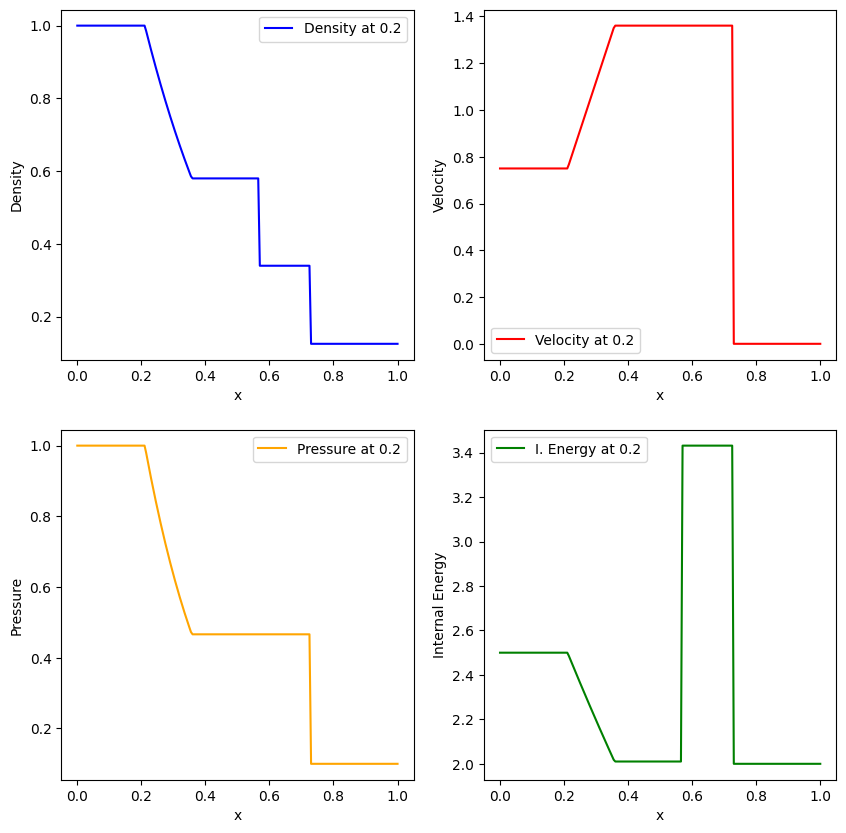

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
idx = 160
axs[0,0].plot(x, ext_den[:,idx], label=f'Density at {T * idx/Nt}', color='blue')
axs[0,0].set_title('')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('Density')
axs[0,0].legend()

axs[1,0].plot(x, ext_pre[:,idx], label=f'Pressure at {T * idx/Nt}', color='orange')
axs[1,0].set_title('')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('Pressure')
axs[1,0].legend()

axs[0,1].plot(x, ext_vel[:, idx], label=f'Velocity at {T * idx/Nt}', color='red')
axs[0,1].set_title('')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('Velocity')
axs[0,1].legend()

axs[1,1].plot(x, ext_ene[:, idx], label=f'I. Energy at {T * idx/Nt}', color='green')
axs[1,1].set_title('')
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('Internal Energy')
axs[1,1].legend()
plt.show()

### Lax-Wendroff

In [16]:
sol_rho_lw = np.zeros((rho.shape[0], Nt+1))
sol_mom_lw = np.zeros((rho.shape[0], Nt+1))
sol_ene_lw = np.zeros((rho.shape[0], Nt+1))
sol_pre_lw = np.zeros((rho.shape[0], Nt+1))


sol_rho_lw[:, 0] = rho
sol_mom_lw[:, 0] = rho * u
sol_ene_lw[:, 0] = energy

In [17]:
diff_rho = np.zeros(Nx)
diff_mom = np.zeros(Nx)
diff_ene = np.zeros(Nx)
v = np.zeros(Nx)
v_prov = np.zeros(Nx-1)
v[sol_rho_lw[:,0]!=0] = sol_mom_lw[:, 0][sol_rho_lw[:,0]!=0]/sol_rho_lw[:,0][sol_rho_lw[:,0]!=0]

for i in range(1, Nt+1):
    press = sol_pre_lw[:,i-1]
    f_rho = sol_mom_lw[:,i-1]
    f_mom = press + sol_rho_lw[:,i-1]*v**2
    f_ene = v * (sol_ene_lw[:,i-1] + press)
    
    u_prov = 0.5*(sol_mom_lw[1:,i-1] + sol_mom_lw[:-1,i-1]) - 0.5*dt*(f_mom[1:] - f_mom[:-1])/dx
    r_prov = 0.5*(sol_rho_lw[1:,i-1] + sol_rho_lw[:-1,i-1]) - 0.5*dt*(f_rho[1:] - f_rho[:-1])/dx
    e_prov = 0.5*(sol_ene_lw[1:,i-1] + sol_ene_lw[:-1,i-1]) - 0.5*dt*(f_ene[1:] - f_ene[:-1])/dx

    v_prov[r_prov!=0] = u_prov[r_prov!=0]/r_prov[r_prov!=0]
    press_prov = (gamma - 1) * (e_prov - 0.5*r_prov * v_prov**2) 
    f_rho_prov = u_prov
    f_mom_prov = press_prov + r_prov*v_prov**2
    f_ene_prov = v_prov*(e_prov + press_prov)

    diff_rho[1:-1] = f_rho_prov[1:] - f_rho_prov[:-1]
    diff_mom[1:-1] = f_mom_prov[1:] - f_mom_prov[:-1]
    diff_ene[1:-1] = f_ene_prov[1:] - f_ene_prov[:-1]

    sol_mom_lw[:,i] = sol_mom_lw[:,i-1] - dt*(diff_mom)/dx
    sol_rho_lw[:,i] = sol_rho_lw[:,i-1] - dt*(diff_rho)/dx
    sol_ene_lw[:,i] = sol_ene_lw[:,i-1] - dt*(diff_ene)/dx

    sol_mom_lw[0,i] = sol_mom_lw[1,i] 
    sol_rho_lw[0,i] = sol_rho_lw[1,i] 
    sol_ene_lw[0,i] = sol_ene_lw[1,i] 
    sol_mom_lw[-1,i] = sol_mom_lw[-2,i] 
    sol_rho_lw[-1,i] = sol_rho_lw[-2,i] 
    sol_ene_lw[-1,i] = sol_ene_lw[-2,i] 
    
    v[sol_rho_lw[:,i]!=0] = sol_mom_lw[:, i][sol_rho_lw[:,i]!=0]/sol_rho_lw[:,i][sol_rho_lw[:,i]!=0]
    sol_pre_lw[:,i] = (gamma - 1) *(sol_ene_lw[:,i] - 0.5* sol_rho_lw[:,i]* v**2)

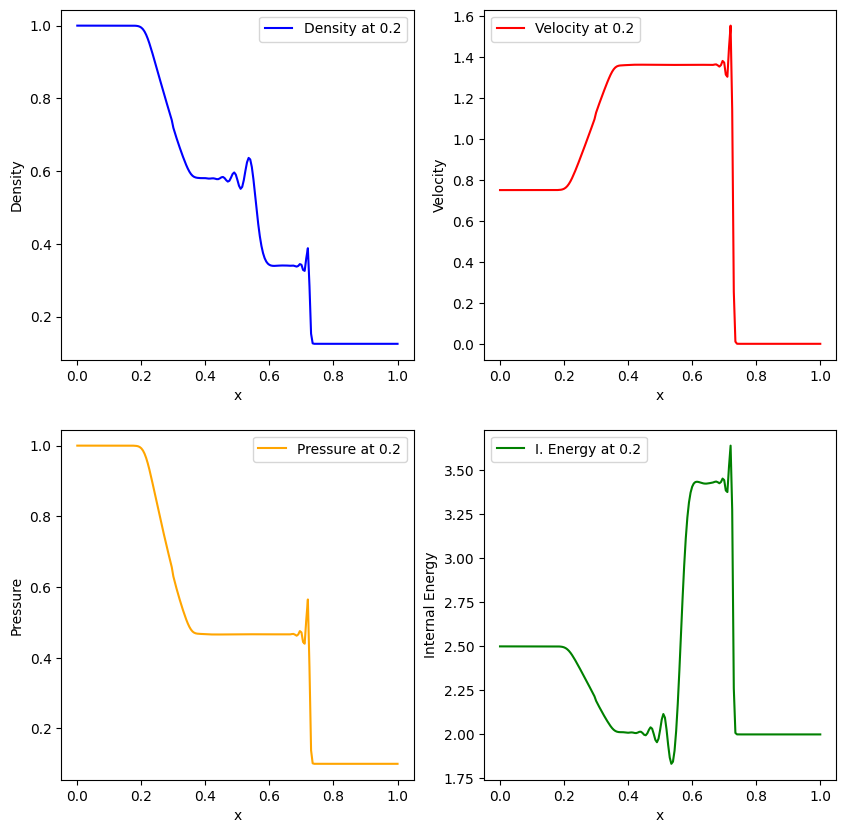

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
idx = 160
axs[0,0].plot(x, sol_rho_lw[:,idx], label=f'Density at {T * idx/Nt}', color='blue')
axs[0,0].set_title('')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('Density')
axs[0,0].legend()

axs[1,0].plot(x, sol_pre_lw[:,idx], label=f'Pressure at {T * idx/Nt}', color='orange')
axs[1,0].set_title('')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('Pressure')
axs[1,0].legend()

axs[0,1].plot(x, sol_mom_lw[:,idx]/sol_rho_lw[:,idx], label=f'Velocity at {T * idx/Nt}', color='red')
axs[0,1].set_title('')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('Velocity')
axs[0,1].legend()

axs[1,1].plot(x, (sol_ene_lw[:,idx]/sol_rho_lw[:,idx] - 0.5*(sol_mom_lw[:,idx]/sol_rho_lw[:,idx])**2), label=f'I. Energy at {T * idx/Nt}', color='green')
axs[1,1].set_title('')
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('Internal Energy')
axs[1,1].legend()
plt.show()

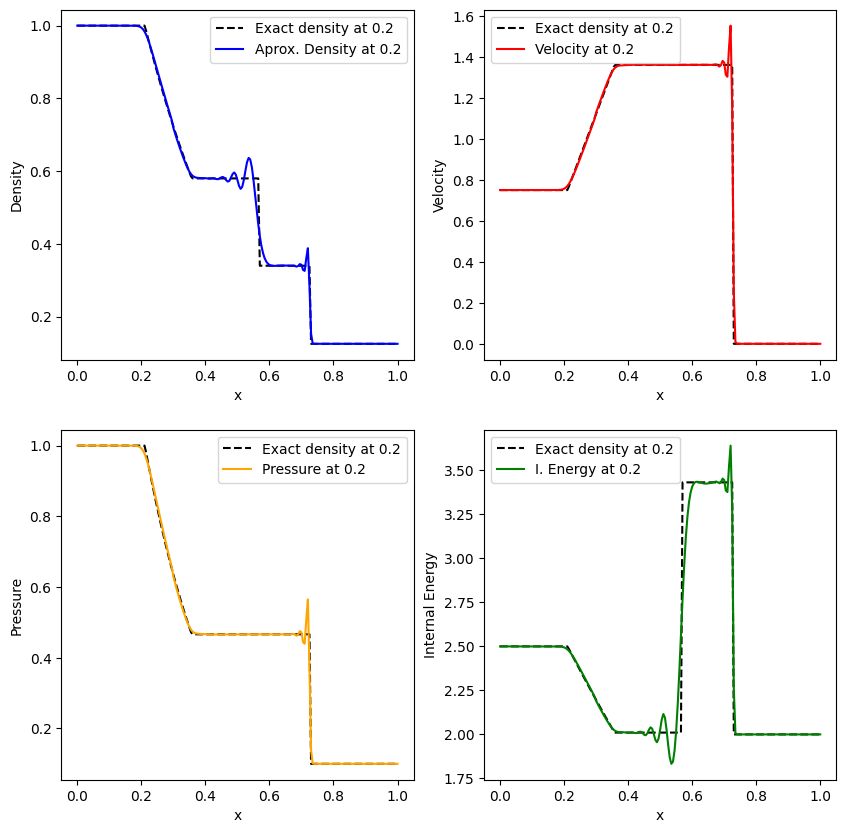

In [20]:
# Comparission
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
idx = 160
axs[0,0].plot(x, ext_den[:,idx], label=f'Exact density at {T * idx/Nt}', color='black', linestyle='dashed')
axs[0,0].plot(x, sol_rho_lw[:,idx], label=f'Aprox. Density at {T * idx/Nt}', color='blue')
axs[0,0].set_title('')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('Density')
axs[0,0].legend()

axs[1,0].plot(x, ext_pre[:,idx], label=f'Exact density at {T * idx/Nt}', color='black', linestyle='dashed')
axs[1,0].plot(x, sol_pre_lw[:,idx], label=f'Pressure at {T * idx/Nt}', color='orange')
axs[1,0].set_title('')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('Pressure')
axs[1,0].legend()

axs[0,1].plot(x, ext_vel[:,idx], label=f'Exact density at {T * idx/Nt}', color='black', linestyle='dashed')
axs[0,1].plot(x, sol_mom_lw[:,idx]/sol_rho_lw[:,idx], label=f'Velocity at {T * idx/Nt}', color='red')
axs[0,1].set_title('')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('Velocity')
axs[0,1].legend()

axs[1,1].plot(x, ext_ene[:,idx], label=f'Exact density at {T * idx/Nt}', color='black', linestyle='dashed')
axs[1,1].plot(x, (sol_ene_lw[:,idx]/sol_rho_lw[:,idx] - 0.5*(sol_mom_lw[:,idx]/sol_rho_lw[:,idx])**2), label=f'I. Energy at {T * idx/Nt}', color='green')
axs[1,1].set_title('')
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('Internal Energy')
axs[1,1].legend()
plt.show()

### ROE 

In [21]:
def trrs(ul, ur, al, ar, pl, pr, Q=2, gamma=1.4):
    z = (gamma-1)/(2*gamma)
    num = al + ar - 0.5*(gamma-1)*(ur-ul)
    den = al/pl**z + ar/pr**z
    p_ = (num/den)**(1/z)
    al_, ar_ = al*(p_/pl)**z, ar*(p_/pr)**z
    ul_, ur_ = ul + 2*(al - al_)/(gamma-1), ur + 2*(ar_ - ar)/(gamma-1) 

    return al_, ar_, ul_, ur_

def roe_flux(rho_l, rho_r, u_l, u_r, e_l, e_r, p_l, p_r, gamma):
    # Obtain entalpy
    h_l = (e_l + p_l)/rho_l
    h_r = (e_r + p_r)/rho_r

    # Obtain Roe averages
    rho_det = np.sqrt(rho_l) + np.sqrt(rho_r)
    rho_avg = np.sqrt(rho_l*rho_r)
    u_avg = (np.sqrt(rho_l)*u_l + np.sqrt(rho_r)*u_r)/rho_det
    h_avg = (np.sqrt(rho_l)*h_l + np.sqrt(rho_r)*h_r)/rho_det
    a_avg =  np.sqrt((gamma-1)*(h_avg - 0.5*u_avg**2))

    # Obtain eigenvalues
    l_1 = u_avg - a_avg
    l_2 = u_avg
    l_3 = u_avg + a_avg

    # Compute coefs
    alp_1 = 0.5*(1/a_avg**2) * (p_r - p_l - rho_avg*a_avg*(u_r - u_l))
    alp_2 = rho_r - rho_l - (p_r - p_l)/a_avg**2
    alp_3 = 0.5*(1/a_avg**2) * (p_r - p_l + rho_avg*a_avg*(u_r - u_l))

    # Compute eigenvectors
    K1 = np.array([np.ones(u_avg.shape[0]), u_avg - a_avg, h_avg - u_avg*a_avg])
    K2 = np.array([np.ones(u_avg.shape[0]), u_avg, 0.5*u_avg**2])
    K3 = np.array([np.ones(u_avg.shape[0]), u_avg + a_avg, h_avg + u_avg*a_avg])

    # Entropy fix
    al, ar = np.sqrt(gamma*p_l/rho_l), np.sqrt(gamma*p_r/rho_r)
    al_, ar_, ul_, ur_ = trrs(u_l, u_r, al, ar, p_l, p_r, gamma=gamma)
    l_1l = u_l - al
    l_1r = ul_ - al_
    l_3l = ur_ + ar_
    l_3r = u_r + ar
    
    idx1 = np.logical_and(l_1l < 0, l_1r > 0)
    idx3 = np.logical_and(l_3l < 0, l_3r > 0)

    idx_t1 = (l_1r - l_1l) != 0
    idx_t3 = (l_3r - l_3l) != 0

    l1_bar = np.zeros(l_1l.shape[0])
    l3_bar = np.zeros(l_1l.shape[0])
    
    l1_bar[idx_t1] = l_1l[idx_t1]*(l_1r[idx_t1] - l_1[idx_t1])/(l_1r[idx_t1] - l_1l[idx_t1])
    l3_bar[idx_t3] = l_3r[idx_t3]*(l_3[idx_t3] - l_3l[idx_t3])/(l_3r[idx_t3] - l_3l[idx_t3])

    # Roe flux
    #idx_body = np.logical_or(np.logical_not(idx1), np.logical_not(idx3))
    flux_rho = 0.5 * (rho_l*u_l + rho_r*u_r)
    flux_rho -= 0.5*(np.abs(l_1)*alp_1*K1[0] + np.abs(l_2)*alp_2*K2[0] + np.abs(l_3)*alp_3*K3[0])
    flux_mom = 0.5 * (rho_l*u_l**2 + p_l + rho_r*u_r**2 + p_r) 
    flux_mom -= 0.5*(np.abs(l_1)*alp_1*K1[1] + np.abs(l_2)*alp_2*K2[1] + np.abs(l_3)*alp_3*K3[1])
    flux_ene = 0.5 * (u_l*(e_l + p_l) + u_r*(e_r + p_r)) 
    flux_ene -= 0.5*(np.abs(l_1)*alp_1*K1[2] + np.abs(l_2)*alp_2*K2[2] + np.abs(l_3)*alp_3*K3[2])

    flux_rho[idx1] = rho_l[idx1] * u_l[idx1] + l1_bar[idx1] * alp_1[idx1]*K1[0][idx1]
    flux_mom[idx1] = rho_l[idx1] * u_l[idx1]**2 + p_l[idx1] + l1_bar[idx1] * alp_1[idx1]*K1[1][idx1]
    flux_ene[idx1] = u_l[idx1]*(e_l[idx1] + p_l[idx1]) + l1_bar[idx1] * alp_1[idx1]*K1[2][idx1]

    flux_rho[idx3] = rho_r[idx3] * u_r[idx3] - l3_bar[idx3] * alp_3[idx3]*K3[0][idx3]
    flux_mom[idx3] = rho_r[idx3] * u_r[idx3]**2 - p_r[idx3] + l3_bar[idx3] * alp_3[idx3]*K3[1][idx3]
    flux_ene[idx3] = u_r[idx3]*(e_r[idx3] + p_r[idx3]) - l3_bar[idx3] * alp_3[idx3]*K3[2][idx3]

    return flux_rho, flux_mom, flux_ene



In [22]:
sol_rho = np.zeros((rho.shape[0], Nt+1))
sol_mom = np.zeros((rho.shape[0], Nt+1))
sol_ene = np.zeros((rho.shape[0], Nt+1))
sol_pre = np.zeros((rho.shape[0], Nt+1))

v = np.zeros(Nx)
diff_rho = np.zeros(Nx)
diff_mom = np.zeros(Nx)
diff_ene = np.zeros(Nx)

sol_rho[:, 0] = rho
sol_mom[:, 0] = rho * u
sol_ene[:, 0] = energy
sol_pre[:, 0] = press_i
v[sol_rho[:,0]!=0] = sol_mom[:, 0][sol_rho[:,0]!=0]/sol_rho[:,0][sol_rho[:,0]!=0]

for i in range(1, Nt + 1):
    flux_rho, flux_mom, flux_ene = roe_flux(sol_rho[:-1, i-1], sol_rho[1:, i-1],
                                            v[:-1], v[1:],
                                            sol_ene[:-1, i-1], sol_ene[1:, i-1],
                                            sol_pre[:-1, i-1], sol_pre[1:, i-1],
                                            gamma)
    
    diff_rho[1:-1] =  (flux_rho[:-1] - flux_rho[1:])
    diff_mom[1:-1] =  (flux_mom[:-1] - flux_mom[1:])
    diff_ene[1:-1] =  (flux_ene[:-1] - flux_ene[1:])
    sol_rho[:,i] = sol_rho[:,i-1] + (dt/dx)*diff_rho
    sol_mom[:,i] = sol_mom[:,i-1] + (dt/dx)*diff_mom
    sol_ene[:,i] = sol_ene[:,i-1] + (dt/dx)*diff_ene
    v[sol_rho[:,i]!=0] = sol_mom[:, i][sol_rho[:,i]!=0]/sol_rho[:,i][sol_rho[:,i]!=0]
    sol_pre[:,i] = (gamma - 1) *(sol_ene[:,i] - 0.5* sol_rho[:,i]* v**2)

    # Boundary Condition
    sol_rho[0,i] = sol_rho[1,i]
    sol_mom[0,i] = sol_mom[1,i]
    sol_ene[0,i] = sol_ene[1,i]
    sol_pre[0,i] = sol_pre[1,i]

    sol_rho[-1,i] = sol_rho[-2,i] 
    sol_mom[-1,i] = sol_mom[-2,i] 
    sol_ene[-1,i] = sol_ene[-2,i] 
    sol_pre[-1,i] = sol_pre[-2,i] 

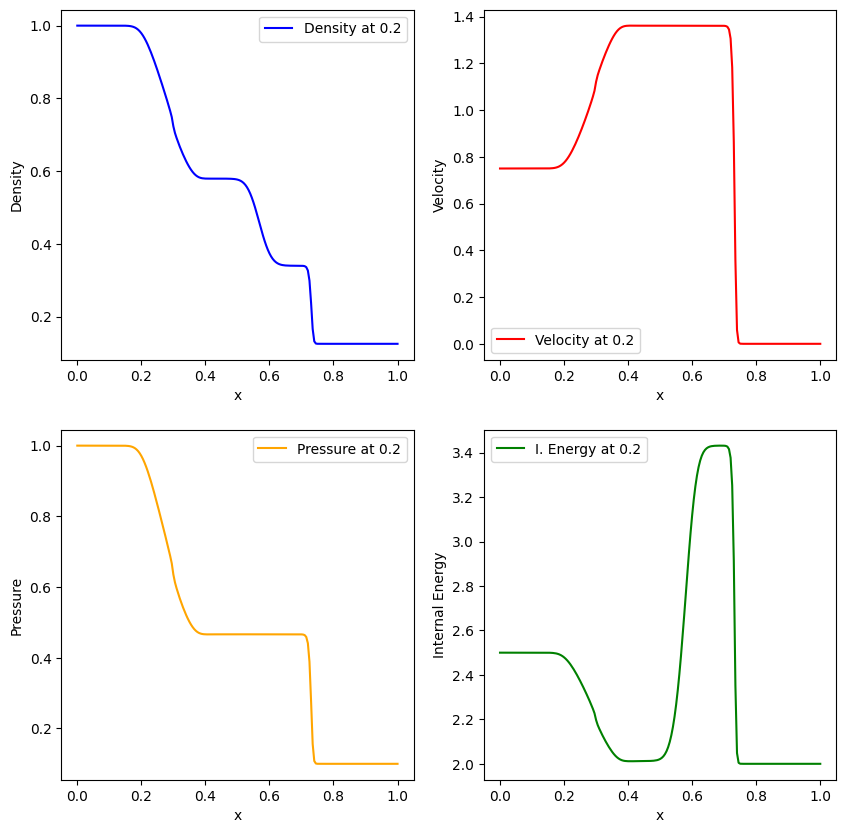

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
idx = 160
axs[0,0].plot(x, sol_rho[:,idx], label=f'Density at {T * idx/Nt}', color='blue')
axs[0,0].set_title('')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('Density')
axs[0,0].legend()

axs[1,0].plot(x, sol_pre[:,idx], label=f'Pressure at {T * idx/Nt}', color='orange')
axs[1,0].set_title('')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('Pressure')
axs[1,0].legend()

axs[0,1].plot(x, sol_mom[:,idx]/sol_rho[:,idx], label=f'Velocity at {T * idx/Nt}', color='red')
axs[0,1].set_title('')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('Velocity')
axs[0,1].legend()

axs[1,1].plot(x, (sol_ene[:,idx]/sol_rho[:,idx] - 0.5*(sol_mom[:,idx]/sol_rho[:,idx])**2), label=f'I. Energy at {T * idx/Nt}', color='green')
axs[1,1].set_title('')
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('Internal Energy')
axs[1,1].legend()
plt.show()

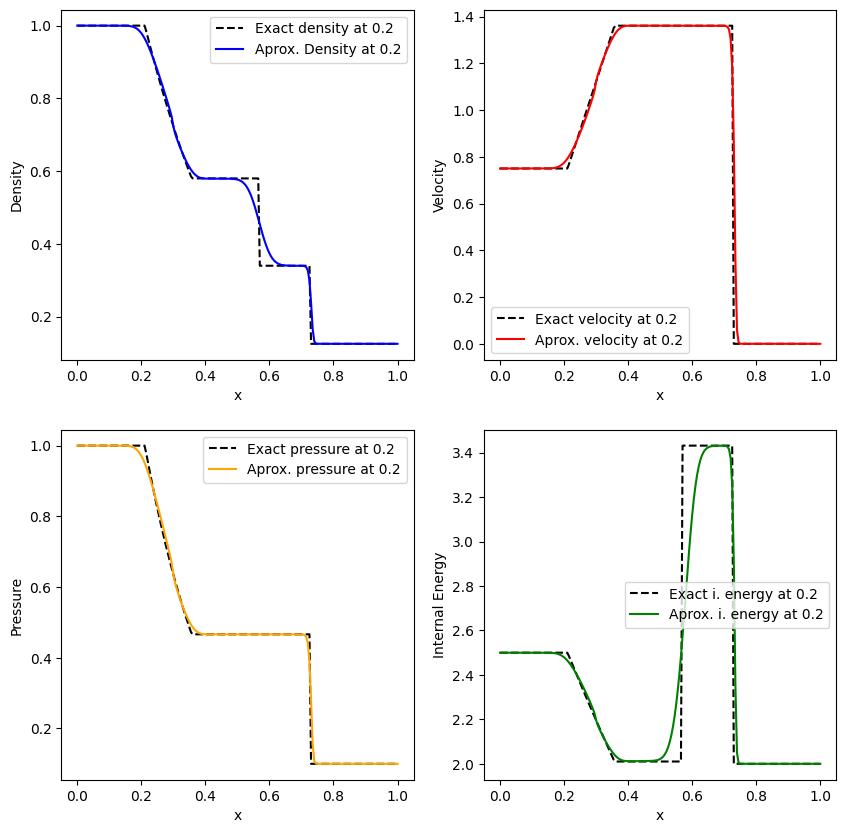

In [24]:
# Comparision
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
idx = 160
axs[0,0].plot(x, ext_den[:,idx], label=f'Exact density at {T * idx/Nt}', color='black', linestyle='dashed')
axs[0,0].plot(x, sol_rho[:,idx], label=f'Aprox. Density at {T * idx/Nt}', color='blue')
axs[0,0].set_title('')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('Density')
axs[0,0].legend()

axs[1,0].plot(x, ext_pre[:,idx], label=f'Exact pressure at {T * idx/Nt}', color='black', linestyle='dashed')
axs[1,0].plot(x, sol_pre[:,idx], label=f'Aprox. pressure at {T * idx/Nt}', color='orange')
axs[1,0].set_title('')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('Pressure')
axs[1,0].legend()

axs[0,1].plot(x, ext_vel[:,idx], label=f'Exact velocity at {T * idx/Nt}', color='black', linestyle='dashed')
axs[0,1].plot(x, sol_mom[:,idx]/sol_rho[:,idx], label=f'Aprox. velocity at {T * idx/Nt}', color='red')
axs[0,1].set_title('')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('Velocity')
axs[0,1].legend()

axs[1,1].plot(x, ext_ene[:,idx], label=f'Exact i. energy at {T * idx/Nt}', color='black', linestyle='dashed')
axs[1,1].plot(x, (sol_ene[:,idx]/sol_rho[:,idx] - 0.5*(sol_mom[:,idx]/sol_rho[:,idx])**2), label=f'Aprox. i. energy at {T * idx/Nt}', color='green')
axs[1,1].set_title('')
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('Internal Energy')
axs[1,1].legend()
plt.show()

## Periodic Boundary Conditions

In [9]:
# Parameters
L = 1.0         # Length of the domain
T = 1.0         # Total simulation time
Nx = 200        # Number of spatial points
Nt = 800        # Number of time steps
dx = L / (Nx - 1)
dt = T / Nt

In [10]:
# Initial conditions
x = np.linspace(0, L, Nx)
gamma = 1.4
u = 0.75*np.ones(Nx) #np.exp(-(x - 0.5*L)**2 / 0.1)             # Velocity
u[60:] = 0
rho = np.ones(Nx)
rho[60:] = 0.125
press = np.ones(Nx)
press[60:] = 0.1

energy = np.zeros(Nx)
energy = press/((gamma - 1)) + 0.5*rho*u**2

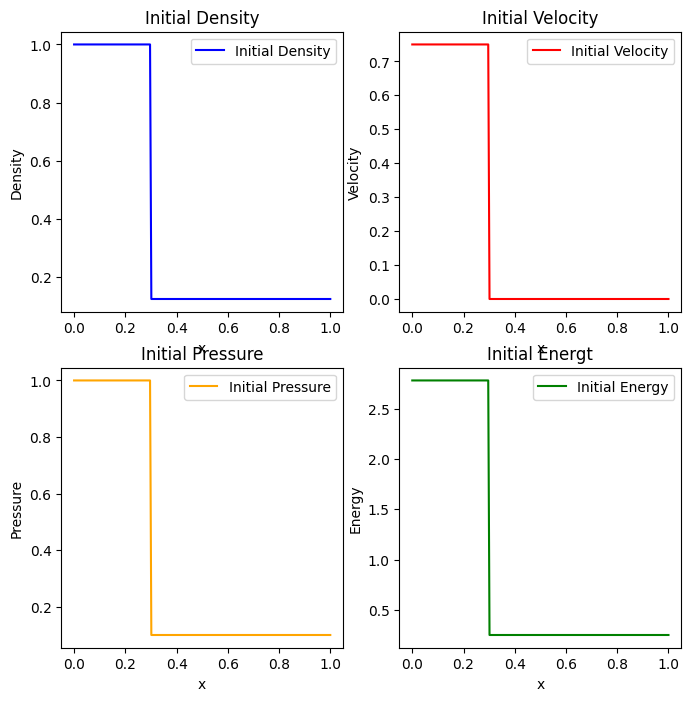

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0,0].plot(x, rho, label='Initial Density', color='blue')
axs[0,0].set_title('Initial Density')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('Density')
axs[0,0].legend()

axs[0,1].plot(x, u, label='Initial Velocity', color='red')
axs[0,1].set_title('Initial Velocity')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('Velocity')
axs[0,1].legend()

axs[1,0].plot(x, press, label='Initial Pressure', color='orange')
axs[1,0].set_title('Initial Pressure')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('Pressure')
axs[1,0].legend()

axs[1,1].plot(x, energy, label='Initial Energy', color='green')
axs[1,1].set_title('Initial Energt')
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('Energy')
axs[1,1].legend()

### ROE

In [12]:
def trrs(ul, ur, al, ar, pl, pr, Q=2, gamma=1.4):
    z = (gamma-1)/(2*gamma)
    num = al + ar - 0.5*(gamma-1)*(ur-ul)
    den = al/pl**z + ar/pr**z
    p_ = (num/den)**(1/z)
    al_, ar_ = al*(p_/pl)**z, ar*(p_/pr)**z
    ul_, ur_ = ul + 2*(al - al_)/(gamma-1), ur + 2*(ar_ - ar)/(gamma-1) 

    return al_, ar_, ul_, ur_

def roe_flux(rho_l, rho_r, u_l, u_r, e_l, e_r, p_l, p_r, gamma):
    N = rho_l.shape[0]
    # Define new data
    rho_l = np.concatenate((rho_l, [rho_r[N-1]]))
    rho_r = np.concatenate((rho_r, [rho_l[0]]))
    u_l = np.concatenate((u_l, [u_r[N-1]]))
    u_r = np.concatenate((u_r, [u_l[0]]))
    e_l = np.concatenate((e_l, [e_r[N-1]]))
    e_r = np.concatenate((e_r, [e_l[0]]))
    p_l = np.concatenate((p_l, [p_r[N-1]]))
    p_r = np.concatenate((p_r, [p_l[0]]))

    # Obtain entalpy
    h_l = (e_l + p_l)/rho_l
    h_r = (e_r + p_r)/rho_r

    # Obtain Roe averages
    rho_det = np.sqrt(rho_l) + np.sqrt(rho_r)
    rho_avg = np.sqrt(rho_l*rho_r)
    u_avg = (np.sqrt(rho_l)*u_l + np.sqrt(rho_r)*u_r)/rho_det
    h_avg = (np.sqrt(rho_l)*h_l + np.sqrt(rho_r)*h_r)/rho_det
    a_avg =  np.sqrt((gamma-1)*(h_avg - 0.5*u_avg**2))

    # Obtain eigenvalues
    l_1 = u_avg - a_avg
    l_2 = u_avg
    l_3 = u_avg + a_avg

    # Compute coefs
    alp_1 = 0.5*(1/a_avg**2) * (p_r - p_l - rho_avg*a_avg*(u_r - u_l))
    alp_2 = rho_r - rho_l - (p_r - p_l)/a_avg**2
    alp_3 = 0.5*(1/a_avg**2) * (p_r - p_l + rho_avg*a_avg*(u_r - u_l))

    # Compute eigenvectors
    K1 = np.array([np.ones(u_avg.shape[0]), u_avg - a_avg, h_avg - u_avg*a_avg])
    K2 = np.array([np.ones(u_avg.shape[0]), u_avg, 0.5*u_avg**2])
    K3 = np.array([np.ones(u_avg.shape[0]), u_avg + a_avg, h_avg + u_avg*a_avg])

    # Entropy fix
    #al, ar = np.sqrt(gamma*p_l/rho_l), np.sqrt(gamma*p_r/rho_r)
    #al_, ar_, ul_, ur_ = trrs(u_l, u_r, al, ar, p_l, p_r, gamma=gamma)
    #l_1l = u_l - al
    #l_1r = ul_ - al_
    #l_3l = ur_ - ar_
    #l_3r = u_r - ar
    
    #idx1 = np.logical_and(l_1l < 0, l_1r > 0)
    #idx3 = np.logical_and(l_3l < 0, l_3r > 0)

    #l1_bar = l_1l*(l_1r - l_1)/(l_1r - l_1l)
    #l3_bar = l_3r*(l_3 - l_3l)/(l_3r - l_3l)

    # Roe flux
    #idx_body = np.logical_or(np.logical_not(idx1), np.logical_not(idx3))
    flux_rho = 0.5 * (rho_l*u_l + rho_r*u_r)
    flux_rho -= 0.5*(np.abs(l_1)*alp_1*K1[0] + np.abs(l_2)*alp_2*K2[0] + np.abs(l_3)*alp_3*K3[0])
    flux_mom = 0.5 * (rho_l*u_l**2 + p_l + rho_r*u_r**2 + p_r) 
    flux_mom -= 0.5*(np.abs(l_1)*alp_1*K1[1] + np.abs(l_2)*alp_2*K2[1] + np.abs(l_3)*alp_3*K3[1])
    flux_ene = 0.5 * (u_l*(e_l + p_l) + u_r*(e_r + p_r)) 
    flux_ene -= 0.5*(np.abs(l_1)*alp_1*K1[2] + np.abs(l_2)*alp_2*K2[2] + np.abs(l_3)*alp_3*K3[2])

    #flux_rho[idx1] = rho_l[idx1] * u_l[idx1] + l1_bar[idx1] * alp_1[idx1]*K1[0][idx1]
    #flux_mom[idx1] = rho_l[idx1] * u_l[idx1]**2 + p_l[idx1] + l1_bar[idx1] * alp_1[idx1]*K1[1][idx1]
    #flux_ene[idx1] = u_l[idx1]*(e_l[idx1] + p_l[idx1]) + l1_bar[idx1] * alp_1[idx1]*K1[2][idx1]

    #flux_rho[idx3] = rho_r[idx3] * u_r[idx3] + l3_bar[idx3] * alp_3[idx3]*K3[0][idx3]
    #flux_mom[idx3] = rho_r[idx3] * u_r[idx3]**2 + p_r[idx3] + l3_bar[idx3] * alp_3[idx3]*K3[1][idx3]
    #flux_ene[idx3] = u_r[idx3]*(e_r[idx3] + p_r[idx3]) + l3_bar[idx3] * alp_3[idx3]*K3[2][idx3]

    return flux_rho, flux_mom, flux_ene

In [13]:
sol_rho = np.zeros((rho.shape[0], Nt+1))
sol_mom = np.zeros((rho.shape[0], Nt+1))
sol_ene = np.zeros((rho.shape[0], Nt+1))
sol_pre = np.zeros((rho.shape[0], Nt+1))

v = np.zeros(Nx)
diff_rho = np.zeros(Nx)
diff_mom = np.zeros(Nx)
diff_ene = np.zeros(Nx)

sol_rho[:, 0] = rho
sol_mom[:, 0] = rho * u
sol_ene[:, 0] = energy
sol_pre[:, 0] = press
v[sol_rho[:,0]!=0] = sol_mom[:, 0][sol_rho[:,0]!=0]/sol_rho[:,0][sol_rho[:,0]!=0]

for i in range(1, Nt + 1):
    flux_rho, flux_mom, flux_ene = roe_flux(sol_rho[:-1, i-1], sol_rho[1:, i-1],
                                            v[:-1], v[1:],
                                            sol_ene[:-1, i-1], sol_ene[1:, i-1],
                                            sol_pre[:-1, i-1], sol_pre[1:, i-1],
                                            gamma)
    
    diff_rho[:-1] =  (flux_rho[:-1] - flux_rho[1:])
    diff_mom[:-1] =  (flux_mom[:-1] - flux_mom[1:])
    diff_ene[:-1] =  (flux_ene[:-1] - flux_ene[1:])
    diff_rho[-1] =  (flux_rho[-1] - flux_rho[0])
    diff_mom[-1] =  (flux_mom[-1] - flux_mom[0])
    diff_ene[-1] =  (flux_ene[-1] - flux_ene[0])
    sol_rho[:,i] = sol_rho[:,i-1] + (dt/dx)*diff_rho
    sol_mom[:,i] = sol_mom[:,i-1] + (dt/dx)*diff_mom
    sol_ene[:,i] = sol_ene[:,i-1] + (dt/dx)*diff_ene
    v[sol_rho[:,i]!=0] = sol_mom[:, i][sol_rho[:,i]!=0]/sol_rho[:,i][sol_rho[:,i]!=0]
    sol_pre[:,i] = (gamma - 1) *(sol_ene[:,i] - 0.5* sol_rho[:,i]* v**2)

C:\Users\daaba\AppData\Local\Temp\ipykernel_19248\1899863600.py:28: RuntimeWarning: invalid value encountered in sqrt
  rho_det = np.sqrt(rho_l) + np.sqrt(rho_r)
C:\Users\daaba\AppData\Local\Temp\ipykernel_19248\1899863600.py:29: RuntimeWarning: invalid value encountered in sqrt
  rho_avg = np.sqrt(rho_l*rho_r)
C:\Users\daaba\AppData\Local\Temp\ipykernel_19248\1899863600.py:30: RuntimeWarning: invalid value encountered in sqrt
  u_avg = (np.sqrt(rho_l)*u_l + np.sqrt(rho_r)*u_r)/rho_det
C:\Users\daaba\AppData\Local\Temp\ipykernel_19248\1899863600.py:31: RuntimeWarning: invalid value encountered in sqrt
  h_avg = (np.sqrt(rho_l)*h_l + np.sqrt(rho_r)*h_r)/rho_det


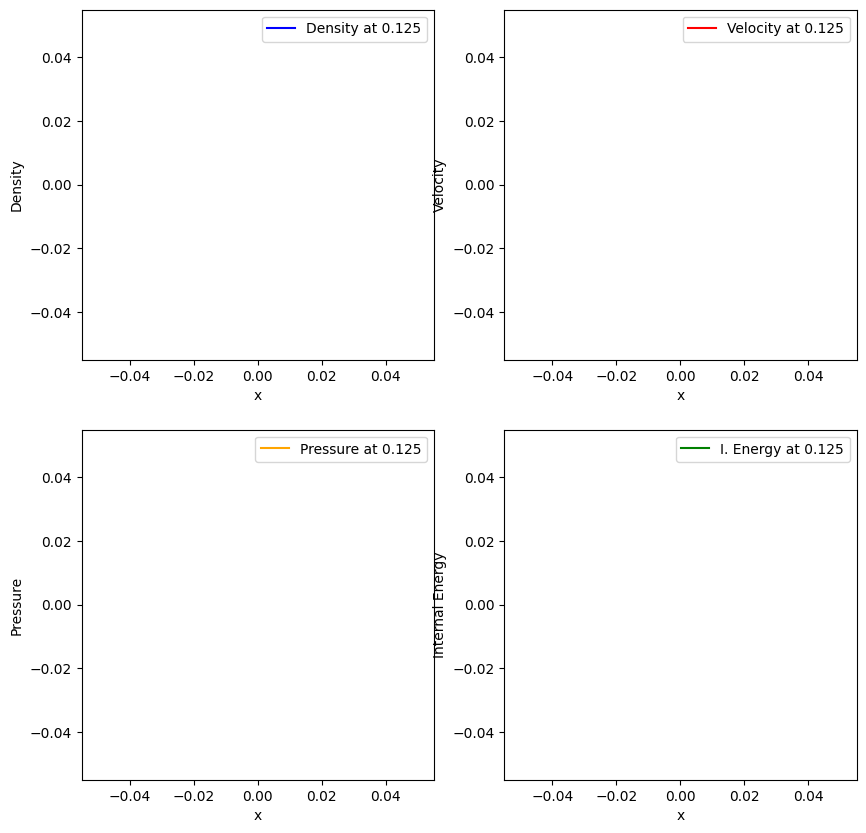

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
idx = 100
axs[0,0].plot(x, sol_rho[:,idx], label=f'Density at {T * idx/Nt}', color='blue')
axs[0,0].set_title('')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('Density')
axs[0,0].legend()

axs[1,0].plot(x, sol_pre[:,idx], label=f'Pressure at {T * idx/Nt}', color='orange')
axs[1,0].set_title('')
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('Pressure')
axs[1,0].legend()

axs[0,1].plot(x, sol_mom[:,idx]/sol_rho[:,idx], label=f'Velocity at {T * idx/Nt}', color='red')
axs[0,1].set_title('')
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('Velocity')
axs[0,1].legend()

axs[1,1].plot(x, (sol_ene[:,idx]/sol_rho[:,idx] - 0.5*(sol_mom[:,idx]/sol_rho[:,idx])**2), label=f'I. Energy at {T * idx/Nt}', color='green')
axs[1,1].set_title('')
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('Internal Energy')
axs[1,1].legend()
plt.show()

## Animations

In [ ]:
# Initialize plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2, color='blue', label='Aprox Roe Density')
line2, = ax.plot([], [], lw=2, color='black', linestyle='dashed', label='Exact Density')
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 6.5)
ax.set_xlabel('x')
ax.set_ylabel('Density')

# Function to initialize plot
def init():
    line.set_data([], [])
    return line,

# Function to animate plot
def animate(i):
    y = sol_rho[:,i]
    y_ext = ext_den[:,i]
    line.set_data(x, y)
    line2.set_data(x, y_ext)
    ax.set_title(f"Solution - {i*dt}") # Update title with file name
    return line,

# Create animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=Nt+1, interval=200, blit=True)

# Save animation as a gif (optional)
ani.save('animations/T1/density_roe.gif', writer='pillow', fps=24)

# Show plot
plt.show()

In [ ]:
# Initialize plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2, color='blue', label='Aprox L-W Density')
line2, = ax.plot([], [], lw=2, color='black', linestyle='dashed', label='Exact Density')
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.2)
ax.set_xlabel('x')
ax.set_ylabel('Density')

# Function to initialize plot
def init():
    line.set_data([], [])
    return line,

# Function to animate plot
def animate(i):
    y = sol_rho_lw[:,i]
    y_ext = ext_den[:,i]
    line.set_data(x, y)
    line2.set_data(x, y_ext)
    ax.set_title(f"Solution - {i*dt}") # Update title with file name
    return line,

# Create animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=Nt+1, interval=200, blit=True)

# Save animation as a gif (optional)
ani.save('animations/T1/density_lw.gif', writer='pillow', fps=24)

# Show plot
plt.show()

In [ ]:
# Initialize plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2, color='blue', label='Aprox Roe Pressure')
line2, = ax.plot([], [], lw=2, color='black', linestyle='dashed', label='Exact Pressure')
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1100)
ax.set_xlabel('x')
ax.set_ylabel('Pressure')

# Function to initialize plot
def init():
    line.set_data([], [])
    return line,

# Function to animate plot
def animate(i):
    y = sol_pre[:,i]
    y_ext = ext_pre[:,i]
    line.set_data(x, y)
    line2.set_data(x, y_ext)
    ax.set_title(f"Solution - {i*dt}") # Update title with file name
    return line,

# Create animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=700+1, interval=200, blit=True)

# Save animation as a gif (optional)
ani.save('animations/T1/pressure_roe.gif', writer='pillow', fps=24)

# Show plot
plt.show()

In [ ]:
# Initialize plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2, color='blue', label='Aprox L-W Pressure')
line2, = ax.plot([], [], lw=2, color='black', linestyle='dashed', label='Exact Pressure')
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.2)
ax.set_xlabel('x')
ax.set_ylabel('Pressure')

# Function to initialize plot
def init():
    line.set_data([], [])
    return line,

# Function to animate plot
def animate(i):
    y = sol_pre_lw[:,i]
    y_ext = ext_pre[:,i]
    line.set_data(x, y)
    line2.set_data(x, y_ext)
    ax.set_title(f"Solution - {i*dt}") # Update title with file name
    return line,

# Create animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=Nt+1, interval=200, blit=True)

# Save animation as a gif (optional)
ani.save('animations/T1/pressure_lw.gif', writer='pillow', fps=24)

# Show plot
plt.show()

In [ ]:
# Initialize plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2, color='blue', label='Aprox Roe Velocity')
line2, = ax.plot([], [], lw=2, color='black', linestyle='dashed', label='Exact Velocity')
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 20.5)
ax.set_xlabel('x')
ax.set_ylabel('Velocity')

# Function to initialize plot
def init():
    line.set_data([], [])
    return line,

# Function to animate plot
def animate(i):
    y = sol_mom[:,i]/sol_rho[:,i]
    y_ext = ext_vel[:,i]
    line.set_data(x, y)
    line2.set_data(x, y_ext)
    ax.set_title(f"Solution - {i*dt}") # Update title with file name
    return line,

# Create animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=Nt+1, interval=200, blit=True)

# Save animation as a gif (optional)
ani.save('animations/T1/velocity_roe.gif', writer='pillow', fps=24)

# Show plot
plt.show()

In [ ]:
# Initialize plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2, color='blue', label='Aprox L-W Velocity')
line2, = ax.plot([], [], lw=2, color='black', linestyle='dashed', label='Exact Velocity')
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 2)
ax.set_xlabel('x')
ax.set_ylabel('Velocity')

# Function to initialize plot
def init():
    line.set_data([], [])
    return line,

# Function to animate plot
def animate(i):
    y = sol_mom_lw[:,i]/sol_rho_lw[:,i]
    y_ext = ext_vel[:,i]
    line.set_data(x, y)
    line2.set_data(x, y_ext)
    ax.set_title(f"Solution - {i*dt}") # Update title with file name
    return line,

# Create animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=Nt+1, interval=200, blit=True)

# Save animation as a gif (optional)
ani.save('animations/T1/velocity_lw.gif', writer='pillow', fps=24)

# Show plot
plt.show()

In [ ]:
# Initialize plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2, color='blue', label='Aprox Roe Int. Energy')
line2, = ax.plot([], [], lw=2, color='black', linestyle='dashed', label='Exact Int. Energy')
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 2600)
ax.set_xlabel('x')
ax.set_ylabel('Internal Energy')

# Function to initialize plot
def init():
    line.set_data([], [])
    return line,

# Function to animate plot
def animate(i):
    y = (sol_ene[:,i]/sol_rho[:,i] - 0.5*(sol_mom[:,i]/sol_rho[:,i])**2)
    y_ext = ext_ene[:,i]
    line.set_data(x, y)
    line2.set_data(x, y_ext)
    ax.set_title(f"Solution - {i*dt}") # Update title with file name
    return line,

# Create animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=Nt+1, interval=200, blit=True)

# Save animation as a gif (optional)
ani.save('animations/T1/energy_roe.gif', writer='pillow', fps=24)

# Show plot
plt.show()

In [ ]:
# Initialize plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2, color='blue', label='Aprox L-W Int. Energy')
line2, = ax.plot([], [], lw=2, color='black', linestyle='dashed', label='Exact Int. Energy')
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(1.5, 3.8)
ax.set_xlabel('x')
ax.set_ylabel('Internal Energy')

# Function to initialize plot
def init():
    line.set_data([], [])
    return line,

# Function to animate plot
def animate(i):
    y = (sol_ene_lw[:,i]/sol_rho_lw[:,i] - 0.5*(sol_mom_lw[:,i]/sol_rho_lw[:,i])**2)
    y_ext = ext_ene[:,i]
    line.set_data(x, y)
    line2.set_data(x, y_ext)
    ax.set_title(f"Solution - {i*dt}") # Update title with file name
    return line,

# Create animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=Nt+1, interval=200, blit=True)

# Save animation as a gif (optional)
ani.save('animations/T1/energy_lw.gif', writer='pillow', fps=24)

# Show plot
plt.show()